<a href="https://colab.research.google.com/github/aliejabbari/multi_label_text_classification/blob/main/Multi_label_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label text classification
**Author:** [Farrokh Karimi](https://github.com/farrokhkarimi)

**Editor:** [Ali Jabbari](https://github.com/aliejabbari)

**Description:** In this notebook, we want to improve our model to have better accuracy in classifying new data in multi-label text classification task.
I tested different Deeplearning Networks architecture to test which one gives better results on this data set and came up with the following answer with simple network architecture.
I obtained accuracy of 84.25% (and 0.654 of loss) , 82.73% and 82.16% from the model using network with dense architecture, deep network with block transformer and deep network with convolutional layer. In all three cases, the accuracy obtained is better than the sample made by the author.

**Import important laibrary**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

**Download and Read Runash Dataset**


In [2]:
# downloading Data from the Google Drive link
!gdown 1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy

Downloading...
From: https://drive.google.com/uc?id=1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy
To: /content/Ronash_DS_Assignment.csv
100% 1.05M/1.05M [00:00<00:00, 133MB/s]


In [3]:
ls

Ronash_DS_Assignment.csv  sample_data/


In [4]:
# reading the csv file as a dataframe
df = pd.read_csv('Ronash_DS_Assignment.csv')
df

,product_id,title,vendor,tags,category
0,3937721221199,Fidele Super Premium Adult Large Breed Dog Food,Fidele,"['Adult', 'Bangalore', 'Chennai', 'Chicken', '...",Animals & Pet Supplies
1,7353058033889,Foldable Pet Toys Linen Storage,Cap Point,[],Animals & Pet Supplies
2,6594773549129,Bok Dok Diaper,Pets Home,"['Brand_Pet Arabia', 'Category_Pets Home', 'Ca...",Animals & Pet Supplies
3,4802008318014,Tastybone Toy Chicken,TastyBone,[],Animals & Pet Supplies
4,1779705151539,Leather Leash Tab - Short Dog Leash,Mighty Paw,"['Leash', 'Leash Tab', 'Training']",Animals & Pet Supplies
...,...,...,...,...,...
5265,4637089464407,Candylab MOO Milk Van,Candylab,"['3 Years +', 'candylab', 'Discount Products',...",Vehicles & Parts
5266,4996632444987,"Truck - Modern Era Vehicles -- Red, White - S...",Woodland Scenics,"['HO Scale', 'ho-scale-items', 'vehicles', 'wo...",Vehicles & Parts
5267,5528541003927,Car Sticker Flags Decal American Flag Sticker for,Cyan Selene,['Other'],Vehicles & Parts
5268,1395163889730,Lazer Helmets Bayamo Pit Bull - Full Face,OPEN BOX BARGAINS,"['65061090', 'Antiscratch Pinlock Ready Visor'...",Vehicles & Parts


**Data prerpocessing**

In [5]:
# counting the number of each label
df['category'].value_counts()

Apparel & Accessories        1000
Animals & Pet Supplies        500
Food, Beverages & Tobacco     400
Sporting Goods                400
Luggage & Bags                400
Home & Garden                 400
Health & Beauty               400
Media                         300
Toys & Games                  300
Furniture                     200
Baby & Toddler                200
Arts & Entertainment          200
Electronics                   100
Business & Industrial         100
Office Supplies               100
Vehicles & Parts              100
Hardware                       50
Cameras & Optics               50
Software                       50
Religious & Ceremonial         20
Name: category, dtype: int64

In [6]:
# counting how many indices are duplicated in each column
print(f"There are {sum(df['title'].duplicated())} duplicate title.")
print(f"There are {sum(df['vendor'].duplicated())} duplicate vondor.")
print(f"There are {sum(df['tags'].duplicated())} duplicate tags.")

There are 0 duplicate title.
There are 1256 duplicate vondor.
There are 716 duplicate tags.


In [7]:
# counting the number of Nan samples
df.isnull().values.sum()

3

There are just 3 Nan samples in the dataset so we can ignore them.

In [8]:
# the function for extracting and standardizing the sentences
def text_extraction(dfi):
  # in this function, we concatenate text feature parts of the data as a sentence
  sentence = ' '.join([dfi['title'], str(dfi['vendor']), dfi['tags']])
  # Remove punctuations
  sentence = re.sub('[^a-zA-Z0-9$.]', ' ', sentence)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  # Changint to lowercase
  sentence = sentence.lower()
  return sentence

# printing 10 sample sentences
for i in range(10):
  print(text_extraction(df.iloc[i]))

fidele super premium adult large breed dog food fidele adult bangalore chennai chicken doberman dog dry foods fidele german shepherd golden retriever great dane highpriority imported labrador less than 1000 less than 2000 less than 500 mastiff orange pet nutrition 
foldable pet toys linen storage cap point 
bok dok diaper pets home brand pet arabia category pets home category small pets supplies type pet home type pet supplies 
tastybone toy chicken tastybone 
leather leash tab short dog leash mighty paw leash leash tab training 
pridebites texas guitar dog toy pride bites brand pridebites toy type plush 
burns sensitive pork potato burns 10 25 25 50 50 75 adult burns coat dog food food delivery jansale18 natural nonsale19 sensitive size 12kg size 2kg size 6kg skin 
bully sticks dog toy adog.co bully sticks dog chew toys dog toys 
kazoo tough giraffe dog toy kazoo brand kazoo june2021 kazoo material plush plush 
orgo dog biscuits fresh milk petku brand orgo category dogs dogs lifestage

In [9]:
# creating the dataset
dataset = pd.DataFrame(columns=['text', 'label'])
for i in range(len(df)):
  dataset = dataset.append({'text':text_extraction(df.iloc[i]), 'label':df.iloc[i]['category']}, ignore_index = True)

# creating integer labels for multiclass training
dataset['label_int'] = pd.Categorical(dataset['label']).codes
dataset

,text,label,label_int
0,fidele super premium adult large breed dog foo...,Animals & Pet Supplies,0
1,foldable pet toys linen storage cap point,Animals & Pet Supplies,0
2,bok dok diaper pets home brand pet arabia cate...,Animals & Pet Supplies,0
3,tastybone toy chicken tastybone,Animals & Pet Supplies,0
4,leather leash tab short dog leash mighty paw l...,Animals & Pet Supplies,0
...,...,...,...
5265,candylab moo milk van candylab 3 years candyla...,Vehicles & Parts,19
5266,truck modern era vehicles red white scale ho w...,Vehicles & Parts,19
5267,car sticker flags decal american flag sticker ...,Vehicles & Parts,19
5268,lazer helmets bayamo pit bull full face open b...,Vehicles & Parts,19


In [10]:
# extracting the names of the labels
labels_names = list(Counter(dataset['label']).keys())
labels_names

['Animals & Pet Supplies',
 'Apparel & Accessories',
 'Arts & Entertainment',
 'Baby & Toddler',
 'Business & Industrial',
 'Cameras & Optics',
 'Electronics',
 'Food, Beverages & Tobacco',
 'Furniture',
 'Hardware',
 'Health & Beauty',
 'Home & Garden',
 'Luggage & Bags',
 'Media',
 'Office Supplies',
 'Religious & Ceremonial',
 'Software',
 'Sporting Goods',
 'Toys & Games',
 'Vehicles & Parts']

In [11]:
# printing each integer label and its corresponding name label
for i, label in enumerate(labels_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Animals & Pet Supplies
Label 1 corresponds to Apparel & Accessories
Label 2 corresponds to Arts & Entertainment
Label 3 corresponds to Baby & Toddler
Label 4 corresponds to Business & Industrial
Label 5 corresponds to Cameras & Optics
Label 6 corresponds to Electronics
Label 7 corresponds to Food, Beverages & Tobacco
Label 8 corresponds to Furniture
Label 9 corresponds to Hardware
Label 10 corresponds to Health & Beauty
Label 11 corresponds to Home & Garden
Label 12 corresponds to Luggage & Bags
Label 13 corresponds to Media
Label 14 corresponds to Office Supplies
Label 15 corresponds to Religious & Ceremonial
Label 16 corresponds to Software
Label 17 corresponds to Sporting Goods
Label 18 corresponds to Toys & Games
Label 19 corresponds to Vehicles & Parts


**Creat train_df and test_df from train test split**

In [12]:
# splitting dataset to train, validation, and test dataframes
train_df, test_df= train_test_split(dataset, test_size=0.2, random_state=42)
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of samples in training set: {len(train_df)}")
print(f"Number of samples in validation set: {len(val_df)}")
print(f"Number of samples in test set: {len(test_df)}")

# extracting texts and labels from dataframes
train_texts = train_df['text']
train_labels = train_df['label_int']
val_texts = val_df['text']
val_labels = val_df['label_int']
test_texts = test_df['text']
test_labels = test_df['label_int']

Number of samples in training set: 4216
Number of samples in validation set: 527
Number of samples in test set: 527


In [13]:
# creating data generators with batch size 32
batch_size = 120
raw_train_batch = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size)
raw_val_batch = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size)
raw_test_batch = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

# printing texts and labels of a batch of raw train
for text, label in raw_train_batch.take(1):
  print('Texts: {}'.format(text))
  print('labels: {}'.format(label))

Texts: [b'housie tambola game by brands with foldable reusable tickets snooplay 13 17 year olds 18 years above 251 500 8 12 year olds age no bar all time favourite below 1000 below 400 below 500 best selling board games creative games gifts customer favourites diwali family friends night family games friends family nights geek gifts for boys gifts for friends gifts for girls gifts for kids gifts for parents googleshopping nerd or geek new new collection outdoor games party accessories party essentials party freak party games party games for grown ups party games for kids premium unique new toys '
 b'foldable waterproof raised dog bed dogiti '
 b'quadrello di bufala cheese cut wrapped by igourmet category cheese cut cheeses milk type buffalo nutrition full set origin italy shipping perishable texture semi soft type stinky and washed rind wholesale cheese collection '
 b'quay vip pink navy to pink lens quay accessories new summer sunglasses '
 b'seachem multitest ammonia seachem '
 b'sma

In [14]:
# counting how many words are there in the whole texts of the dataset
num_of_words = 0
for i in dataset['text']: num_of_words += len(i.split())
print(num_of_words)

112572


There are about 112000 words in the texts.



In [15]:
# counting max sequence length and how many non-repetitive words are there in the whole texts of the dataset
l = []
max_seq_lenght = 0
for i in dataset['text']:
  lenght = len(i.split())
  if lenght > max_seq_lenght: max_seq_lenght = lenght
  for j in i.split():
    if j not in l: l.append(j)

print(max_seq_lenght)
print(len(l))

309
18933


Maximum sequence length is 309 and There are about 19000 non-repetitive words in the whole dataset texts. So we set max word features to 10000 and sequence length to 350.

In [16]:
# setting the text vectorization layer with 10000 words and 350 sequence length
max_features = 19000
sequence_length = 309

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# fitting the state of the preprocessing layer to the train set. This will cause the model to build an index of strings to integers.
vectorize_layer.adapt(train_texts)

# defining the vectorize text function
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieving a sample from a batch of texts and labels from the train set
text_batch, label_batch = next(iter(raw_train_batch))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized text", vectorize_text(first_review, first_label))

Review tf.Tensor(b'housie tambola game by brands with foldable reusable tickets snooplay 13 17 year olds 18 years above 251 500 8 12 year olds age no bar all time favourite below 1000 below 400 below 500 best selling board games creative games gifts customer favourites diwali family friends night family games friends family nights geek gifts for boys gifts for friends gifts for girls gifts for kids gifts for parents googleshopping nerd or geek new new collection outdoor games party accessories party essentials party freak party games party games for grown ups party games for kids premium unique new toys ', shape=(), dtype=string)
Label tf.Tensor(18, shape=(), dtype=int8)
Vectorized text (<tf.Tensor: shape=(1, 309), dtype=int64, numpy=
array([[12501,  9229,   192,    23,   343,    51,  1546,  2392,  9089,
         9635,   740,  1609,   275,  2882,   372,    69,   959, 15878,
          134,   109,    89,   275,  2882,    35,    55,   381,    16,
          480,  7346,   783,   181,   783,

In [17]:
# getting corresponding word of each integer 
print("1401 ---> ",vectorize_layer.get_vocabulary()[1401])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1401 --->  heel
 313 --->  is
Vocabulary size: 16230


In [18]:
# creating train, val, and test vectorized dataset and prefetching them
train_ds = raw_train_batch.map(vectorize_text)
val_ds = raw_val_batch.map(vectorize_text)
test_ds = raw_test_batch.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Generating the model**

---



---

At firs we generate a simple model with Embedding and GlobalAveragePooling1D and a dense.

This is the best model with 84% accuracy 

In [19]:
# model configuration
embedding_dim = 256 #embeding_dim changed to 256 
num_of_labels = 20

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.15),#dropout rate chenged to 0.15
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.20),#dropout rate chenged to 0.20
  layers.Dense(num_of_labels)])


In [20]:
# model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# training the model
epochs = 500
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=15,
                                            verbose=1)
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
36/36 [==============================] - 19s 359ms/step - loss: 2.8840 - accuracy: 0.1743 - val_loss: 2.7719 - val_accuracy: 0.1879
Epoch 2/500
36/36 [==============================] - 0s 9ms/step - loss: 2.7136 - accuracy: 0.1881 - val_loss: 2.6716 - val_accuracy: 0.1879
Epoch 3/500
36/36 [==============================] - 0s 8ms/step - loss: 2.6705 - accuracy: 0.1881 - val_loss: 2.6525 - val_accuracy: 0.1879
Epoch 4/500
36/36 [==============================] - 0s 8ms/step - loss: 2.6565 - accuracy: 0.1883 - val_loss: 2.6428 - val_accuracy: 0.1879
Epoch 5/500
36/36 [==============================] - 0s 8ms/step - loss: 2.6466 - accuracy: 0.1883 - val_loss: 2.6342 - val_accuracy: 0.1879
Epoch 6/500
36/36 [==============================] - 0s 9ms/step - loss: 2.6360 - accuracy: 0.1883 - val_loss: 2.6247 - val_accuracy: 0.1879
Epoch 7/500
36/36 [==============================] - 0s 9ms/step - loss: 2.6229 - accuracy: 0.1886 - val_loss: 2.6144 - val_accuracy: 0.1879
Epoch 8/50

Validation of the model

In [22]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 4ms/step - loss: 0.6540 - accuracy: 0.8425
Loss:  0.6540117263793945
Accuracy:  0.8425047397613525


In [23]:
# extracting the history of training and its keys
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

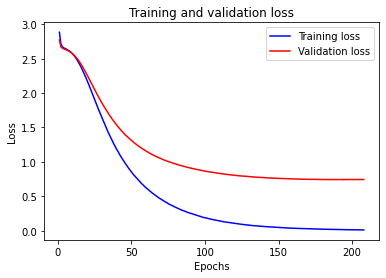

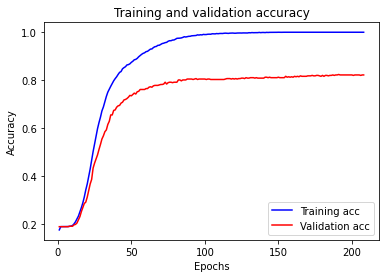

In [25]:
# ploting of loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# plotting of accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()



---
**Second one is a CNN model** with 0.8216318488121033 accuracy


In [26]:
# model configuration
embedding_dim = 4096
num_of_labels = 20

model_1 = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(5),
    layers.Dropout(0.15),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.15),
    layers.Dense(num_of_labels, activation='softmax')
])

In [27]:
# model compilation
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# training the model
epochs = 500
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=30,
                                            verbose=1)
history_1 = model_1.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 16s 238ms/step - loss: 2.7621 - accuracy: 0.1592 - val_loss: 2.5084 - val_accuracy: 0.2884
Epoch 2/500
36/36 [==============================] - 3s 83ms/step - loss: 2.1624 - accuracy: 0.3722 - val_loss: 1.7193 - val_accuracy: 0.5199
Epoch 3/500
36/36 [==============================] - 3s 81ms/step - loss: 1.2222 - accuracy: 0.6864 - val_loss: 1.1408 - val_accuracy: 0.7381
Epoch 4/500
36/36 [==============================] - 3s 81ms/step - loss: 0.5593 - accuracy: 0.8520 - val_loss: 0.9715 - val_accuracy: 0.7647
Epoch 5/500
36/36 [==============================] - 3s 84ms/step - loss: 0.2732 - accuracy: 0.9319 - val_loss: 0.9160 - val_accuracy: 0.7761
Epoch 6/500
36/36 [==============================] - 3s 83ms/step - loss: 0.1474 - accuracy: 0.9680 - val_loss: 0.9267 - val_accuracy: 0.7894
Epoch 7/500
36/36 [==============================] - 3s 82ms/step - loss: 0.0777 - accuracy: 0.9846 - val_loss: 0.9243 - val_accuracy: 0.7951
Epoch 8/500
36/3

In [28]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model_1.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 33ms/step - loss: 1.1318 - accuracy: 0.8216
Loss:  1.131848931312561
Accuracy:  0.8216318488121033


In [31]:
# creating the probability model for testing
probability_model = tf.keras.Sequential([model_1, tf.keras.layers.Softmax()])

# predicting test samples
predictions = probability_model.predict(raw_test_batch.map(vectorize_text))


5/5 [==============================] - 0s 33ms/step


In [32]:
# extracting the history of training and its keys
history_dict = history_1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

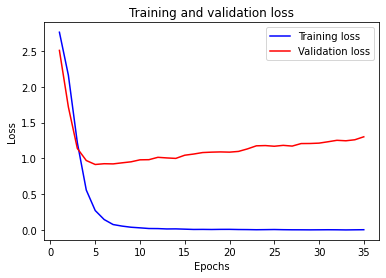

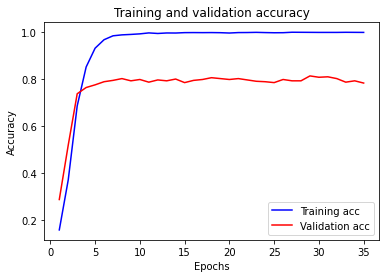

In [34]:
# ploting of loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# plotting of accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()



---
**Genarete a model with Transformer block** with 0.8273244500160217 accuracy 


In [35]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [36]:
embedding_dim = 128
num_heads = 4
ff_dim = 128
dropout_rate = 0.20
num_of_labels = 20

inputs = layers.Input(shape=(309,))
embedding_layer = layers.Embedding(max_features + 1, embedding_dim)(inputs)
transformer_layer = TransformerBlock(embedding_dim, num_heads, ff_dim, dropout_rate)(embedding_layer)
pooling_layer = layers.GlobalAveragePooling1D()(transformer_layer)
dropout_layer = layers.Dropout(0.15)(pooling_layer)
outputs = layers.Dense(num_of_labels, activation="softmax")(dropout_layer)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [37]:
# model compilation
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# training the model
epochs = 500
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=30,
                                            verbose=1)
history_2 = model_2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
36/36 [==============================] - 12s 211ms/step - loss: 2.8723 - accuracy: 0.1383 - val_loss: 2.6829 - val_accuracy: 0.1879
Epoch 2/500
36/36 [==============================] - 3s 85ms/step - loss: 2.7393 - accuracy: 0.1622 - val_loss: 2.6476 - val_accuracy: 0.2334
Epoch 3/500
36/36 [==============================] - 3s 87ms/step - loss: 2.5453 - accuracy: 0.2367 - val_loss: 2.3817 - val_accuracy: 0.2543
Epoch 4/500
36/36 [==============================] - 3s 86ms/step - loss: 1.6460 - accuracy: 0.5199 - val_loss: 1.1455 - val_accuracy: 0.7249
Epoch 5/500
36/36 [==============================] - 3s 87ms/step - loss: 0.4371 - accuracy: 0.8895 - val_loss: 1.0007 - val_accuracy: 0.7837
Epoch 6/500
36/36 [==============================] - 3s 89ms/step - loss: 0.0949 - accuracy: 0.9791 - val_loss: 1.0543 - val_accuracy: 0.7989
Epoch 7/500
36/36 [==============================] - 3s 89ms/step - loss: 0.0226 - accuracy: 0.9972 - val_loss: 1.1205 - val_accuracy: 0.8102
Epoc

In [38]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model_2.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 37ms/step - loss: 1.2518 - accuracy: 0.8273
Loss:  1.2517801523208618
Accuracy:  0.8273244500160217


In [39]:
# showing the first test sample result label
np.argmax(predictions[0])

2

In [40]:
# showing the true label of the first test sample
test_df.iloc[0]

text         dk twist jaded dreams mad tosh 2020 dk dk twis...
label                                     Arts & Entertainment
label_int                                                    2
Name: 1536, dtype: object

In [41]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.7 MB/s eta 0:00:00




---

**TUNING CNN Model**

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from kerastuner.tuners import RandomSearch

# Define hyperparameters
embedding_dim = 128
num_filters = 64
kernel_size = 5
dense_units = 128
dropout_rate = 0.5
max_features = 10000

# Define the text vectorization layer
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=500)

# Define the model builder function for hyperparameter tuning
def build_model(hp):
    # Define hyperparameters
    embedding_dim = hp.Int('embedding_dim', min_value=3, max_value=4096, step=64)
    num_filters = hp.Int('num_filters', min_value=32, max_value=128, step=4)
    kernel_size = hp.Int('kernel_size', min_value=3, max_value=9, step=2)
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)

    # Define the model architecture
    model_3 = keras.Sequential([
        layers.Embedding(max_features+1, embedding_dim),
        layers.Conv1D(num_filters, kernel_size, activation='relu'),
        layers.MaxPooling1D(),
        layers.Conv1D(num_filters, kernel_size, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dropout(dropout_rate),
        layers.Dense(20)
    ])

    # Compile the model
    model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model_3

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project')

# Fit the tuner to the data
tuner.search(train_ds,
             validation_data=val_ds,
             epochs=400,
             callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss', patience=10)])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 01m 23s]
val_accuracy: 0.8007590174674988

Best val_accuracy So Far: 0.8159393072128296
Total elapsed time: 00h 22m 28s


In [43]:
 # model compilation
best_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# training the model
epochs = 500
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=30,
                                            verbose=1)
history_best = best_model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
36/36 [==============================] - 8s 188ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.9240 - val_accuracy: 0.8102
Epoch 2/500
36/36 [==============================] - 5s 128ms/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 1.0005 - val_accuracy: 0.8046
Epoch 3/500
36/36 [==============================] - 5s 133ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 1.0596 - val_accuracy: 0.8083
Epoch 4/500
36/36 [==============================] - 5s 130ms/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 1.1881 - val_accuracy: 0.8065
Epoch 5/500
36/36 [==============================] - 5s 131ms/step - loss: 0.0096 - accuracy: 0.9964 - val_loss: 1.3152 - val_accuracy: 0.7628
Epoch 6/500
36/36 [==============================] - 5s 133ms/step - loss: 0.0198 - accuracy: 0.9957 - val_loss: 1.2913 - val_accuracy: 0.7723
Epoch 7/500
36/36 [==============================] - 5s 133ms/step - loss: 0.0086 - accuracy: 0.9983 - val_loss: 1.3168 - val_accuracy: 0.7818

In [44]:
 # printing loss and accuracy of the model on the test set
loss, accuracy = best_model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 42ms/step - loss: 1.7301 - accuracy: 0.8140
Loss:  1.7301099300384521
Accuracy:  0.8140417337417603




---

**TUNING Dense Model**

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from kerastuner.tuners import RandomSearch

# Define hyperparameters
embedding_dim = 128
num_filters = 64
kernel_size = 5
dense_units = 128
dropout_rate = 0.5
max_features = 10000

# Define the model builder function for hyperparameter tuning
def build_model(hp):
    # Define hyperparameters
    embedding_dim = hp.Int('embedding_dim', min_value=3, max_value=4096, step=64)
    num_filters = hp.Int('num_filters', min_value=32, max_value=128, step=4)
    kernel_size = hp.Int('kernel_size', min_value=3, max_value=9, step=2)
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)

    # Define the model architecture
    model_4 = keras.Sequential([
        layers.Embedding(max_features+1, embedding_dim),
        layers.Dropout(0.15),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(dropout_rate),
        layers.Dense(20)
    ])

    # Compile the model
    model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model_4

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='',
    project_name='')

# Fit the tuner to the data
tuner.search(train_ds,
             validation_data=val_ds,
             epochs=400,
             callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss', patience=10)])
# Get the best model


Trial 20 Complete [00h 03m 56s]
val_accuracy: 0.8159393072128296

Best val_accuracy So Far: 0.8197343349456787
Total elapsed time: 00h 58m 07s


In [46]:
best_model_2 = tuner.get_best_models(num_models=1)[0]

In [47]:
# model compilation
best_model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# training the model
epochs = 500
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=30,
                                            verbose=1)
history_best_2 = best_model_2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
36/36 [==============================] - 6s 145ms/step - loss: 0.0318 - accuracy: 0.9988 - val_loss: 0.7879 - val_accuracy: 0.8083
Epoch 2/500
36/36 [==============================] - 2s 56ms/step - loss: 0.0277 - accuracy: 0.9991 - val_loss: 0.7899 - val_accuracy: 0.8159
Epoch 3/500
36/36 [==============================] - 2s 57ms/step - loss: 0.0250 - accuracy: 0.9991 - val_loss: 0.7934 - val_accuracy: 0.8159
Epoch 4/500
36/36 [==============================] - 2s 56ms/step - loss: 0.0228 - accuracy: 0.9988 - val_loss: 0.7968 - val_accuracy: 0.8140
Epoch 5/500
36/36 [==============================] - 2s 56ms/step - loss: 0.0208 - accuracy: 0.9993 - val_loss: 0.7976 - val_accuracy: 0.8102
Epoch 6/500
36/36 [==============================] - 2s 56ms/step - loss: 0.0191 - accuracy: 0.9991 - val_loss: 0.8028 - val_accuracy: 0.8197
Epoch 7/500
36/36 [==============================] - 2s 56ms/step - loss: 0.0176 - accuracy: 0.9993 - val_loss: 0.8026 - val_accuracy: 0.8159
Epoch

In [48]:
 # printing loss and accuracy of the model on the test set
loss, accuracy = best_model_2 .evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 9ms/step - loss: 0.7885 - accuracy: 0.8273
Loss:  0.7885050177574158
Accuracy:  0.8273244500160217


**Author:** https://Aliejabbari.github.io/

**Author:** https://Aliejabbari.github.io/